# Regularisation in Python

## Ridge Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import scale
from sklearn import model_selection  # cross_validation
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

C:\Users\Andrew\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
# plot in a separate (IPython) window:
# %matplotlib qt5  
# plot in the notebook:
%matplotlib inline  

In [6]:
df = pd.read_csv('Hitters.csv').dropna().drop('Player', axis=1)
df.info()
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 20 columns):
AtBat        263 non-null int64
Hits         263 non-null int64
HmRun        263 non-null int64
Runs         263 non-null int64
RBI          263 non-null int64
Walks        263 non-null int64
Years        263 non-null int64
CAtBat       263 non-null int64
CHits        263 non-null int64
CHmRun       263 non-null int64
CRuns        263 non-null int64
CRBI         263 non-null int64
CWalks       263 non-null int64
League       263 non-null object
Division     263 non-null object
PutOuts      263 non-null int64
Assists      263 non-null int64
Errors       263 non-null int64
Salary       263 non-null float64
NewLeague    263 non-null object
dtypes: float64(1), int64(16), object(3)
memory usage: 43.1+ KB


,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,0,1,0,1,0,1
2,1,0,0,1,1,0
3,0,1,1,0,0,1
4,0,1,1,0,0,1
5,1,0,0,1,1,0
6,0,1,1,0,1,0
7,1,0,0,1,1,0
8,0,1,0,1,0,1
9,1,0,1,0,1,0
10,1,0,1,0,1,0


In [10]:
y = df.Salary
# Drop the column with the independent variable (Salary), and columns for which we created dummy:
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X:
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()
X

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 19 columns):
AtBat          263 non-null float64
Hits           263 non-null float64
HmRun          263 non-null float64
Runs           263 non-null float64
RBI            263 non-null float64
Walks          263 non-null float64
Years          263 non-null float64
CAtBat         263 non-null float64
CHits          263 non-null float64
CHmRun         263 non-null float64
CRuns          263 non-null float64
CRBI           263 non-null float64
CWalks         263 non-null float64
PutOuts        263 non-null float64
Assists        263 non-null float64
Errors         263 non-null float64
League_N       263 non-null uint8
Division_W     263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: float64(16), uint8(3)
memory usage: 35.7 KB


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0,1
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0,1
5,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0,1,0
6,185.0,37.0,1.0,23.0,8.0,21.0,2.0,214.0,42.0,1.0,30.0,9.0,24.0,76.0,127.0,7.0,1,0,0
7,298.0,73.0,0.0,24.0,24.0,7.0,3.0,509.0,108.0,0.0,41.0,37.0,12.0,121.0,283.0,9.0,0,1,0
8,323.0,81.0,6.0,26.0,32.0,8.0,2.0,341.0,86.0,6.0,32.0,34.0,8.0,143.0,290.0,19.0,1,1,1
9,401.0,92.0,17.0,49.0,66.0,65.0,13.0,5206.0,1332.0,253.0,784.0,890.0,866.0,0.0,0.0,0.0,0,0,0
10,574.0,159.0,21.0,107.0,75.0,59.0,10.0,4631.0,1300.0,90.0,702.0,504.0,488.0,238.0,445.0,22.0,0,0,0


In [31]:
alphas = 10**(np.linspace(10,-2,100)*0.5)
print(alphas)
alphas2 = 10**np.linspace(5, -1, 100)
print(alphas2)

[1.00000000e+05 8.69749003e+04 7.56463328e+04 6.57933225e+04
 5.72236766e+04 4.97702356e+04 4.32876128e+04 3.76493581e+04
 3.27454916e+04 2.84803587e+04 2.47707636e+04 2.15443469e+04
 1.87381742e+04 1.62975083e+04 1.41747416e+04 1.23284674e+04
 1.07226722e+04 9.32603347e+03 8.11130831e+03 7.05480231e+03
 6.13590727e+03 5.33669923e+03 4.64158883e+03 4.03701726e+03
 3.51119173e+03 3.05385551e+03 2.65608778e+03 2.31012970e+03
 2.00923300e+03 1.74752840e+03 1.51991108e+03 1.32194115e+03
 1.14975700e+03 1.00000000e+03 8.69749003e+02 7.56463328e+02
 6.57933225e+02 5.72236766e+02 4.97702356e+02 4.32876128e+02
 3.76493581e+02 3.27454916e+02 2.84803587e+02 2.47707636e+02
 2.15443469e+02 1.87381742e+02 1.62975083e+02 1.41747416e+02
 1.23284674e+02 1.07226722e+02 9.32603347e+01 8.11130831e+01
 7.05480231e+01 6.13590727e+01 5.33669923e+01 4.64158883e+01
 4.03701726e+01 3.51119173e+01 3.05385551e+01 2.65608778e+01
 2.31012970e+01 2.00923300e+01 1.74752840e+01 1.51991108e+01
 1.32194115e+01 1.149757

## Make a Ridge Regression Model (Regularised Regression)
- Try different values of alpha to compare the affect on the weights

In [32]:
ridge = Ridge(normalize=True)  # normalize=True ensures all variables on same scale
coefs = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
np.shape(coefs)
coefs

[array([ 1.20887420e-05,  4.38516147e-05,  1.76695488e-04,  7.41561389e-05,
         7.83318477e-05,  9.21923888e-05,  3.77020033e-04,  1.03793092e-06,
         3.81989303e-06,  2.88072356e-05,  7.66355822e-06,  7.90896083e-06,
         8.36757191e-06,  4.84208465e-06,  7.90883080e-07, -3.68819039e-06,
        -1.28768567e-04, -1.73390009e-03, -2.55554420e-05]),
 array([ 1.38989676e-05,  5.04182228e-05,  2.03154468e-04,  8.52606882e-05,
         9.00616316e-05,  1.05997824e-04,  4.33476058e-04,  1.19335482e-06,
         4.39190086e-06,  3.31209547e-05,  8.81113365e-06,  9.09328406e-06,
         9.62056204e-06,  5.56718619e-06,  9.09316962e-07, -4.24059385e-06,
        -1.48043626e-04, -1.99355604e-03, -2.93762957e-05]),
 array([ 1.59802396e-05,  5.79680724e-05,  2.33575092e-04,  9.80279474e-05,
         1.03547724e-04,  1.21870392e-04,  4.98385041e-04,  1.37205018e-06,
         5.04955544e-06,  3.80805656e-05,  1.01305356e-05,  1.04549361e-05,
         1.10611600e-05,  6.40086565e-06, 

Text(0,0.5,'weights')

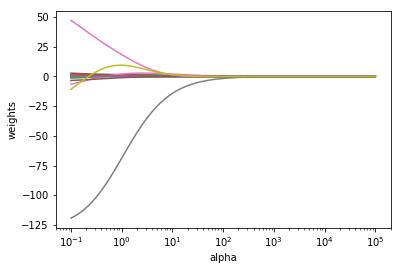

In [33]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [114]:
# Use the cross-validation package to split data into training and test sets:
X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, test_size=0.5, random_state=1)

# fit a ridge regression model on the training set, and evaluate its MSE on the test set, using lambda = 4:
ridge2 = Ridge(alpha=4, normalize=True)
ridge2.fit(X_train, y_train) # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test) # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index=X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred2)) # Calculate the test MSE

AtBat           0.098658
Hits            0.446094
HmRun           1.412107
Runs            0.660773
RBI             0.843403
Walks           1.008473
Years           2.779882
CAtBat          0.008244
CHits           0.034149
CHmRun          0.268634
CRuns           0.070407
CRBI            0.070060
CWalks          0.082795
PutOuts         0.104747
Assists        -0.003739
Errors          0.268363
League_N        4.241051
Division_W    -30.768885
NewLeague_N     4.123474
dtype: float64
106216.52238005561


In [35]:
# least squares is ridge regression with alpha = 0:
ridge2 = Ridge(alpha=0, normalize=True)
ridge2.fit(X_train, y_train) # Fit a ridge regression on the training data
pred = ridge2.predict(X_test) # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index=X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred)) # Calculate the test MSE

AtBat           -1.821115
Hits             4.259156
HmRun           -4.773401
Runs            -0.038760
RBI              3.984578
Walks            3.470126
Years            9.498236
CAtBat          -0.605129
CHits            2.174979
CHmRun           2.979306
CRuns            0.266356
CRBI            -0.598456
CWalks           0.171383
PutOuts          0.421063
Assists          0.464379
Errors          -6.024576
League_N       133.743163
Division_W    -113.743875
NewLeague_N    -81.927763
dtype: float64
116690.46856660416


In [36]:
# try a huge value of alpha:
ridge3 = Ridge(alpha=10**10, normalize=True)
ridge3.fit(X_train, y_train) # Fit a ridge regression on the training data
pred3 = ridge3.predict(X_test) # Use this model to predict the test data
print(pd.Series(ridge3.coef_, index=X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred3)) # Calculate the test MSE

AtBat          1.317464e-10
Hits           4.647486e-10
HmRun          2.079865e-09
Runs           7.726175e-10
RBI            9.390640e-10
Walks          9.769219e-10
Years          3.961442e-09
CAtBat         1.060533e-11
CHits          3.993605e-11
CHmRun         2.959428e-10
CRuns          8.245247e-11
CRBI           7.795451e-11
CWalks         9.894387e-11
PutOuts        7.268991e-11
Assists       -2.615885e-12
Errors         2.084514e-10
League_N      -2.501281e-09
Division_W    -1.549951e-08
NewLeague_N   -2.023196e-09
dtype: float64
172862.23580379886


In [115]:
# use cross-validation to improve the ridge:
ridgecv = RidgeCV(scoring='neg_mean_squared_error', normalize=True, alphas=np.linspace(0.1,100,100), store_cv_values=True)
ridgecv.fit(X_train, y_train)
print(ridgecv.alpha_)
print(np.linspace(0.1,100,100))

1.1090909090909091
[  0.1          1.10909091   2.11818182   3.12727273   4.13636364
   5.14545455   6.15454545   7.16363636   8.17272727   9.18181818
  10.19090909  11.2         12.20909091  13.21818182  14.22727273
  15.23636364  16.24545455  17.25454545  18.26363636  19.27272727
  20.28181818  21.29090909  22.3         23.30909091  24.31818182
  25.32727273  26.33636364  27.34545455  28.35454545  29.36363636
  30.37272727  31.38181818  32.39090909  33.4         34.40909091
  35.41818182  36.42727273  37.43636364  38.44545455  39.45454545
  40.46363636  41.47272727  42.48181818  43.49090909  44.5
  45.50909091  46.51818182  47.52727273  48.53636364  49.54545455
  50.55454545  51.56363636  52.57272727  53.58181818  54.59090909
  55.6         56.60909091  57.61818182  58.62727273  59.63636364
  60.64545455  61.65454545  62.66363636  63.67272727  64.68181818
  65.69090909  66.7         67.70909091  68.71818182  69.72727273
  70.73636364  71.74545455  72.75454545  73.76363636  74.7727272

In [117]:
ridgecv.cv_values_

array([[-215.4831173 , -145.96767846, -114.73704494, ...,   -4.10516631,
          -4.04247135,   -3.98099405],
       [ -39.59926996,   53.37186506,   63.59857294, ...,    6.39553611,
           6.32044053,    6.24674605],
       [  54.22763225,  102.97643148,  101.30109262, ...,    8.10640932,
           8.01402453,    7.92338265],
       ...,
       [-190.91789914,  -91.01776077,  -61.63575838, ...,   -3.15428678,
          -3.128185  ,   -3.10258831],
       [-210.68394552, -250.88564076, -236.36972379, ...,  -21.50344941,
         -21.27960885,  -21.05996002],
       [ 297.63134719,  313.41321456,  291.48190905, ...,   27.18838521,
          26.90720137,   26.63126914]])

In [68]:
ridgecv.coef_

array([-6.73996099e-03,  8.49812598e-01, -2.09510702e-01,  7.27543674e-01,
        1.30618867e+00,  2.06542111e+00,  1.29514375e+00,  6.84650032e-03,
        5.16392038e-02,  5.06004695e-01,  1.06010692e-01,  1.26618885e-01,
        9.97465704e-02,  2.76230510e-01, -1.74229123e-02, -2.84706407e-01,
        1.85285414e+01, -9.08800324e+01,  1.00578352e+01])

In [67]:
X_train.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors', 'League_N', 'Division_W', 'NewLeague_N'],
      dtype='object')

In [62]:
?RidgeCV

In [116]:
# test MSE?
ridge4 = Ridge(alpha=ridgecv.alpha_, normalize=True)
ridge4.fit(X_train, y_train)
mean_squared_error(y_test, ridge4.predict(X_test))

99611.22901875997

In [ ]:
# Finally, refit our ridge regression model on the full data set, using the value of alpha chosen by cross-validation, 
# and examine the coefficient estimates:
ridge4.fit(X, y)
pd.Series(ridge4.coef_, index=X.columns)

In [ ]:
# prepare arrays for plotting:
y_p = ridge4.predict(X)  # predicted response values over the entire data set
y_d = np.array(y)        # actual response values over the entire data set
e = y_d - y_p

In [ ]:
for i in range(y_p.shape[0]):
    plt.plot(y_d[i], y_p[i], 'o', color='green', markersize=3)
y_d12 = [y_d[0], y_d[y_d.shape[0] - 1]]
i1 = y_d.argmin()
i2 = y_d.argmax()
y_d12 = [y_d[i1], y_d[i2]]
plt.plot(y_d12, y_d12, c='blue', linewidth=2)
plt.title('predicted vs actual y-values')
plt.xlabel('actual')
plt.ylabel('predicted')

In [ ]:
fig = plt.figure(figsize=[16,4])
for i in range(y_p.shape[0]):
    plt.plot([i, i], [y_d[i], y_p[i]], color='grey', linewidth=1)
    plt.plot(i, y_p[i], 'o', color='red', markersize=2)
    plt.plot(i, y_d[i], 'o', color='blue', markersize=2)
plt.title('predicted (red) and actual (blue) y-values')
plt.xlabel('index')

In [ ]:
for i in range(y_p.shape[0]):
    plt.plot(i, e[i], 'o', color='red', markersize=3)
plt.plot([0, y_p.shape[0]], [0, 0], c='blue', linewidth=2)
plt.title('residuals')
plt.xlabel('index')

In [ ]:
_ = sm.qqplot(e, line='s')    #: bug in statsmodels/IPython interface: suppress double-plot by capturing return value

## LASSO Regression

In [ ]:
lasso = Lasso(max_iter=10000, normalize=True)
coefs = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [ ]:
# perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:
lassocv = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(X_train, y_train)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

In [ ]:
pd.Series(lasso.coef_, index=X.columns)